 **This is an interesting dataset for building Deep Learning Neural Networks. **

In [1]:
# Import the necessary libraries

# TensorFlow 
import tensorflow as tf


# Helper libraries
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from os.path import join
import cv2
import pandas
import os
import random

C:\Users\Anjana Tiha\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Set the path of the input folder 

data = "flowers/"

# List out the directories inside the main input folder

folders = os.listdir(data)

print(folders)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [3]:
# Import the images and resize them to a 128*128 size
# Also generate the corresponding labels

image_names = []
train_labels = []
train_images = []

size = 64,64

for folder in folders:
    for file in os.listdir(os.path.join(data,folder)):
        if file.endswith("jpg"):
            image_names.append(os.path.join(data,folder,file))
            train_labels.append(folder)
            img = cv2.imread(os.path.join(data,folder,file))
            im = cv2.resize(img,size)
            train_images.append(im)
        else:
            continue
      

In [4]:
len(train_images)


4323

In [5]:
# Transform the image array to a numpy type

train = np.array(train_images)

train.shape

X = train.reshape(train.shape[0],-1).T
# Reduce the RGB values between 0 and 1

X = X.astype('float32') / 255.0
label_dummies = pandas.get_dummies(train_labels)

labels =  label_dummies.values.argmax(1)

def one_hot_encoding(Y,C):
    Y = np.eye(C)[Y.reshape(-1)].T
    
    return Y

Y = one_hot_encoding(labels,5)

Y.shape,X.shape

((5, 4323), (12288, 4323))

In [8]:


def create_placeholders(n_x, n_y):
    X = tf.placeholder(tf.float32, [n_x, None], name="X")
    Y = tf.placeholder(tf.float32, [n_y, None], name="Y")
    return X,Y

def initialize_parameters():
    tf.set_random_seed(1)
    
    W1 = tf.get_variable("W1", [100, 12288], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable("b1", [100, 1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [80, 100], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable("b2", [80, 1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [70, 80], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable("b3", [70 ,1], initializer = tf.zeros_initializer())
    W4 = tf.get_variable("W4", [5, 70], initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b4 = tf.get_variable("b4", [5, 1],initializer = tf.zeros_initializer())
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3,
                  "W4":W4,
                  "b4":b4}
    
    return parameters


def forward_propagation(X, parameters):
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    W4 = parameters["W4"]
    b4 = parameters["b4"]
    
    Z1 = tf.add(tf.matmul(W1, X), b1) 
    
    A1 = tf.nn.relu(Z1)
    
    Z2 = tf.add(tf.matmul(W2, A1), b2)
    
    A2 = tf.nn.relu(Z2) 
    
    Z3 = tf.add(tf.matmul(W3, A2), b3)
    
    A3 = tf.nn.relu(Z3)
    
    Z4 = tf.add(tf.matmul(W4,A3), b4)
    
    return Z4
        
        
def compute_cost(Z4, Y,parameters):
    
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    W4 = parameters["W4"]
    logits = tf.transpose(Z4)
    labels = tf.transpose(Y)
    
    regularizers = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(W3) + tf.nn.l2_loss(W4)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    new_cost = tf.reduce_mean(cost + 0.01*regularizers)
    return new_cost

def model(X_train, Y_train, learning_rate = 0.0001,
          num_epochs = 1500, print_cost = True):
    
    tf.reset_default_graph() 
    tf.set_random_seed(1)
    (n_x, m) = X_train.shape
    n_y = Y_train.shape[0] 
    costs = []
    seed = 3
    
    X, Y = create_placeholders(n_x, n_y)
    parameters = initialize_parameters()
    Z4 = forward_propagation(X, parameters)
    cost = compute_cost(Z4, Y,parameters)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):
            
            epoch_cost = 0.
            
            seed = seed + 1
            
                
            _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: X_train, Y: Y_train})
                
            epoch_cost += temp_cost 
                
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        parameters = sess.run(parameters)
        print("Parameters have been trained!")
        
        correct_prediction = tf.equal(tf.argmax(Z4), tf.argmax(Y))
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        
        
        return parameters
    
    

Cost after epoch 0: 3.448506
Cost after epoch 100: 2.301710
Cost after epoch 200: 1.850902
Cost after epoch 300: 1.547394
Cost after epoch 400: 1.340718
Cost after epoch 500: 1.192049
Cost after epoch 600: 1.079519
Cost after epoch 700: 0.991356
Cost after epoch 800: 0.915712
Cost after epoch 900: 0.859034
Cost after epoch 1000: 0.800612
Cost after epoch 1100: 1.101828
Cost after epoch 1200: 0.885790
Cost after epoch 1300: 0.798844
Cost after epoch 1400: 0.760037


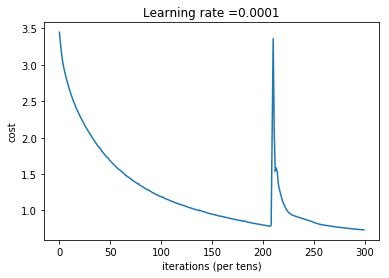

Parameters have been trained!
Train Accuracy: 0.99861205


In [9]:
parameters = model(X,Y)